In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


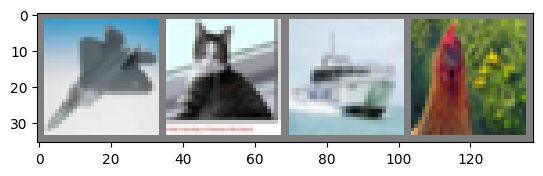

plane cat   ship  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32x32 -> 32x32
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)                           # 32x32 -> 16x16
        self.drop1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 16x16 -> 16x16
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # 16x16 -> 16x16
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)                           # 16x16 -> 8x8
        self.drop2 = nn.Dropout(0.25)

        # Fully connected block
        self.fc1   = nn.Linear(128 * 8 * 8, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.drop_fc = nn.Dropout(0.5)
        self.fc2   = nn.Linear(512, 10)  # 10 output classes

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.drop2(x)

        # Flatten and Fully Connected Layers
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.drop_fc(x)
        x = self.fc2(x)
        return x

# Instantiate the improved network
net = ImprovedNet()

if __name__ == '__main__':
    dummy_input_large_batch = torch.randn(2, 3, 32, 32)
    output_large_batch = net(dummy_input_large_batch)
    print("Output shape with batch size 2:", output_large_batch.shape)

    net.eval()
    dummy_input_single = torch.randn(1, 3, 32, 32)
    output_single = net(dummy_input_single)
    print("Output shape with batch size 1 in eval mode:", output_single.shape)


Output shape with batch size 2: torch.Size([2, 10])
Output shape with batch size 1 in eval mode: torch.Size([1, 10])


In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),
                       lr=0.001,
                       betas=(0.9, 0.999),
                       eps=1e-08,
                       weight_decay=0,
                       amsgrad=False)

In [ ]:
help(optim)

Help on package torch.optim in torch:

NAME
    torch.optim - :mod:`torch.optim` is a package implementing various optimization algorithms.

DESCRIPTION
    Most commonly used methods are already supported, and the interface is general
    enough, so that more sophisticated ones can also be easily integrated in the
    future.

PACKAGE CONTENTS
    _adafactor
    _functional
    _multi_tensor (package)
    adadelta
    adagrad
    adam
    adamax
    adamw
    asgd
    lbfgs
    lr_scheduler
    nadam
    optimizer
    radam
    rmsprop
    rprop
    sgd
    sparse_adam
    swa_utils

CLASSES
    builtins.object
        torch.optim.optimizer.Optimizer
            Adafactor
            torch.optim.adadelta.Adadelta
            torch.optim.adagrad.Adagrad
            torch.optim.adam.Adam
            torch.optim.adamax.Adamax
            torch.optim.adamw.AdamW
            torch.optim.asgd.ASGD
            torch.optim.lbfgs.LBFGS
            torch.optim.nadam.NAdam
            torch.opti

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.854
[1,  4000] loss: 1.499
[1,  6000] loss: 1.341
[1,  8000] loss: 1.208
[1, 10000] loss: 1.128
[1, 12000] loss: 1.105
[2,  2000] loss: 0.989
[2,  4000] loss: 0.977
[2,  6000] loss: 0.959
[2,  8000] loss: 0.950
[2, 10000] loss: 0.926
[2, 12000] loss: 0.937
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

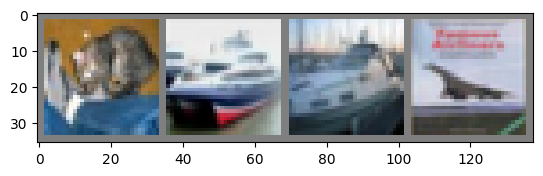

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

NameError: name 'Net' is not defined

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 67 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.9 %
Accuracy for class: car   is 76.6 %
Accuracy for class: bird  is 66.2 %
Accuracy for class: cat   is 41.9 %
Accuracy for class: deer  is 46.3 %
Accuracy for class: dog   is 59.7 %
Accuracy for class: frog  is 69.6 %
Accuracy for class: horse is 75.0 %
Accuracy for class: ship  is 89.1 %
Accuracy for class: truck is 79.5 %


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
net.to(device)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)